# Inhomogeneous Geometric Brownian Motion fixed step size simulations

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

def BM(T, N):
#Define time discretization
    h = T/N
    h_fine = h/16
    t = np.arange(0, T+h, h)
    t_fine = np.arange(0, T+h_fine, h_fine)

# Generate the fine Brownian incements and path
    W_fine = np.zeros(16*N+1)
    dW_fine = np.zeros(16*N)
    W_fine[0]= 0
    for i in range(16*N):
        dW_fine[i] = np.random.normal(0, np.sqrt(h_fine))
        W_fine[i+1] = W_fine[i] + dW_fine[i]

# Define the crude Brownian increments
    dW_crude = np.zeros(N)
    for i in range(N):
        dW_crude[i] = np.sum(dW_fine[16*i:16*(i+1)])

    BMoutputs = {
        'step size': h,
        'fine step size': h_fine,
        'num steps': N,
        'fine delta W': dW_fine, 
        'crude delta W': dW_crude
    }
    return BMoutputs

## Specify parameters

In [2]:
#specify the parameters of the IGBM
a = 0.1
b = 0.04
sigma = 0.6

#in Stratonovich form
a_tilde = a + (sigma**2)/2
b_tilde = 2*a*b/(2*a + sigma**2)

#specify the initial condition
Y_0 = 0.06

constants = {
    'a': a, 
    'b': b, 
    'vol': sigma, 
    'a tilde': a_tilde, 
    'b tilde': a_tilde, 
    'IV': Y_0
}


### Euler Maruyama

In [3]:
def euler(BMoutputs, constants):
    a = constants['a']
    b = constants['b']
    sigma = constants['vol']
    Y_0 = constants['IV']

    h = BMoutputs['step size']
    h_fine = BMoutputs['fine step size']
    N = BMoutputs['num steps']
    dW_fine = BMoutputs['fine delta W']
    dW_crude = BMoutputs['crude delta W']

    #Initialize the outputs Y and Y_fine
    Y= np.zeros(N+1)
    Y[0] = Y_0
    Y_fine = np.zeros(16*N+1)
    Y_fine[0] = Y_0

    #compute the crude Euler Maruyama approximations
    for i in range(N):
        Y[i+1] = Y[i] + a*(b - Y[i])*h + sigma*Y[i]*dW_crude[i]

    #compute the fine Euler Maruyama approximations
    for i in range(16*N):
        Y_fine[i+1] = Y_fine[i] + a*(b - Y_fine[i])*h_fine + sigma*Y_fine[i]*dW_fine[i]

    #compute the strong error term
    E_N = (Y[-1]-Y_fine[-1])**2
    return E_N

#plot the error for different step sizes, i.e. different N
#x = h
#y = E_N
#fig, ax = plt.subplots()
#ax.plot(x, y, linewidth=2.0)
#ax.set_xlabel('h')
#ax.set_ylabel('E_N)
#plt.show()

### Milstein

In [4]:
def milstein(BMoutputs, constants):
    a = constants['a']
    b = constants['b']
    sigma = constants['vol']
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    Y_0 = constants['IV']

    h = BMoutputs['step size']
    h_fine = BMoutputs['fine step size']
    N = BMoutputs['num steps']
    dW_fine = BMoutputs['fine delta W']
    dW_crude = BMoutputs['crude delta W']

    #Initialize the outputs Y and Y_fine
    Y= np.zeros(N+1)
    Y[0] = Y_0
    Y_fine = np.zeros(16*N+1)
    Y_fine[0] = Y_0

    #compute the crude Milstein approximations
    for i in range(N):
        Y[i+1] = Y[i] + a_tilde*(b_tilde - Y[i])*h + sigma*Y[i]*dW_crude[i] + (1/2)*(sigma**2)*Y[i]*((dW_crude[i])**2)

    #compute the fine Milstein approximations
    for i in range(16*N):
        Y_fine[i+1] = Y_fine[i] + a_tilde*(b_tilde - Y_fine[i])*h_fine + sigma*Y_fine[i]*dW_fine[i] + (1/2)*(sigma**2)*Y_fine[i]*((dW_fine[i])**2)

    #compute the strong error term
    E_N = (Y[-1]-Y_fine[-1])**2
    return E_N

### Heun's

In [5]:
def heun(BMoutputs, constants):
    a = constants['a']
    b = constants['b']
    sigma = constants['vol']
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    Y_0 = constants['IV']

    h = BMoutputs['step size']
    h_fine = BMoutputs['fine step size']
    N = BMoutputs['num steps']
    dW_fine = BMoutputs['fine delta W']
    dW_crude = BMoutputs['crude delta W']

    #Initialize the outputs Y and Y_fine
    Y= np.zeros(N+1)
    Y[0] = Y_0
    Y_tilde = np.zeros(N+1)
    Y_fine = np.zeros(16*N+1)
    Y_fine[0] = Y_0
    Y_fine_tilde = np.zeros(16*N+1)

    #compute the crude Heun's approximations
    for i in range(N):
        Y_tilde[i] = Y[i] + h*a_tilde*(b_tilde - Y[i]) + sigma*Y[i]*dW_crude[i]
        Y[i+1] = Y[i] + (1/2)*h*(a_tilde*(b_tilde - Y[i]) + a_tilde*(b_tilde - Y_tilde[i])) + (1/2)*(sigma*Y[i] + sigma*Y_tilde[i])*dW_crude[i]

    #compute the fine Heun's approximations
    for i in range(16*N):
        Y_fine_tilde[i] = Y_fine[i] + h_fine*a_tilde*(b_tilde - Y_fine[i]) + sigma*Y_fine[i]*dW_fine[i]
        Y_fine[i+1] = Y_fine[i] + (1/2)*h_fine*(a_tilde*(b_tilde - Y_fine[i]) + a_tilde*(b_tilde - Y_fine_tilde[i])) + (1/2)*(sigma*Y_fine[i] + sigma*Y_fine_tilde[i])*dW_fine[i]


    #compute the strong error term
    E_N = (Y[-1]-Y_fine[-1])**2
    return E_N

#### sampling and error calculations

In [6]:
# Initialize lists to store errors and step sizes as numpy arrays
EM_errors_means = np.array([])
Mil_errors_means = np.array([])
Heun_errors_means = np.array([])
step_sizes = np.array([])

no_samples = 10000
T = 1
for N in [2, 10, 25, 50, 100, 200]:
    step_sizes =  np.append(step_sizes, T/N)
    n=1
    EM_errors = np.array([])
    Mil_errors = np.array([])
    Heun_errors = np.array([])
    for i in tqdm(range(no_samples)):
        BMoutputs = BM(T, N)

        EM_error = euler(BMoutputs, constants)
        Mil_error = milstein(BMoutputs, constants)
        Heun_error = heun(BMoutputs, constants)

        EM_errors = np.append(EM_errors, EM_error)
        Mil_errors = np.append(Mil_errors, Mil_error)
        Heun_errors = np.append(Heun_errors, Heun_error)

    EM_mean_N = m.sqrt((np.sum(EM_errors))/no_samples)
    EM_errors_means = np.append(EM_errors_means, EM_mean_N)
    Mil_mean_N = m.sqrt((np.sum(Mil_errors))/no_samples)
    Mil_errors_means = np.append(Mil_errors_means, Mil_mean_N)
    Heun_mean_N = m.sqrt((np.sum(Heun_errors))/no_samples)
    Heun_errors_means = np.append(Heun_errors_means, Heun_mean_N)

# Calculate logarithm base 10 of step sizes and errors
log_step_sizes = -np.log10(step_sizes)
log_EM_errors = -np.log10(EM_errors_means)
log_Mil_errors = -np.log10(Mil_errors_means)
log_Heun_errors = -np.log10(Heun_errors_means)



100%|██████████| 10000/10000 [04:25<00:00, 37.60it/s]


#### -log(Error) vs -log(h) plotting

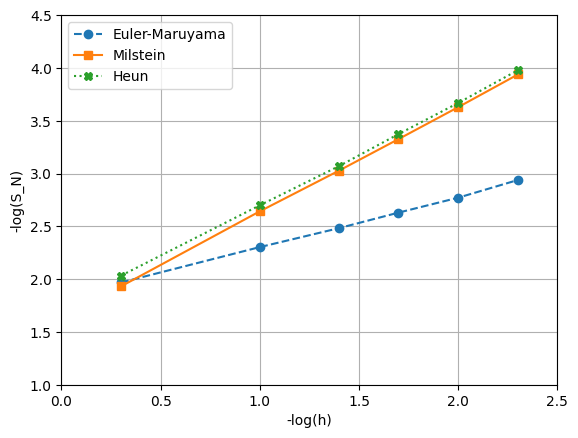

Euler-Maruyama Fit: Slope = 0.48019758173427063 , Intercept = 1.819389524693757
Milstein Fit: Slope = 0.9992669357007897 , Intercept = 1.6334306060320767
Heun Fit: Slope = 0.970065201267368 , Intercept = 1.7306154178145357


In [8]:

# Assuming you have step_sizes, EM_errors, Mil_errors, and Heun_errors defined
# take regression of log and plot

# Perform linear regression
slope_EM, intercept_EM, _, _, _ = linregress(log_step_sizes, log_EM_errors)
slope_Mil, intercept_Mil, _, _, _ = linregress(log_step_sizes, log_Mil_errors)
slope_Heun, intercept_Heun, _, _, _ = linregress(log_step_sizes, log_Heun_errors)

# Plot the best-fit lines
plt.plot(log_step_sizes, log_EM_errors, label='Euler-Maruyama', linestyle='--', marker="o")
plt.plot(log_step_sizes, log_Mil_errors, label='Milstein', linestyle='-', marker="s")
plt.plot(log_step_sizes, log_Heun_errors, label='Heun', linestyle='dotted', marker="X")

plt.xlabel('-log(h)')
plt.ylabel('-log(S_N)')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim(0, 2.5)
plt.ylim(1, 4.5)
plt.show()

print("Euler-Maruyama Fit: Slope =", slope_EM, ", Intercept =", intercept_EM)
print("Milstein Fit: Slope =", slope_Mil, ", Intercept =", intercept_Mil)
print("Heun Fit: Slope =", slope_Heun, ", Intercept =", intercept_Heun)